In [ ]:
!pip install tensorflow-object-detection-api
!pip install tensorflow
!pip install tensorflow keras opencv-python
!pip install ultralytics
!pip install tensorflowjs

# **Load Dataset**

In [ ]:
# load dataset
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0
100% 534M/534M [00:25<00:00, 23.3MB/s]
100% 534M/534M [00:25<00:00, 21.8MB/s]


In [ ]:
!unzip vegetable-image-dataset.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Vegetable Images/train/Radish/0001.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0002.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0003.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0004.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0005.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0006.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0007.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0008.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0009.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0010.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0011.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0012.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0013.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0014.jpg  
  inflating: dataset/Vegetable Images/train/Radish/0015.jpg  
  inflating: datase

In [ ]:
base_dir = "dataset/Vegetable Images"

In [ ]:
import tensorflow as tf

# load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_dir}/train",
    image_size=(224, 224),
    batch_size=32
)

# menentukan nama kelas dan jumlah kelas
class_names = dataset.class_names
num_classes = len(class_names)

print(f"Class Names: {class_names}")
print(f"Number of Classes: {num_classes}")

Found 15000 files belonging to 15 classes.
Class Names: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']
Number of Classes: 15


# **Pre-trained MobileNet**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# load model MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False)

# menambahkan layer deteksi objek
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze layer MobileNetV2 untuk transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/tmp/ipykernel_13964/1015277785.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


# **Preprocessing**

In [ ]:
batch_size = 32
img_size = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_dir}/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_dir}/validation",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f"{base_dir}/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


In [ ]:
from tensorflow.keras.layers import Rescaling

# melakukan normalisasi data
normalization_layer = Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
# prefetching data (untuk mempercepat proses training)
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras import Sequential

# augmentasi data
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomTranslation(0.2, 0.2)
])

# menerapkan augmentasi pada train_dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
# menampilkan dataset
print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)
print("Test Dataset:", test_dataset)

Train Dataset: <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>


# **Fine-Tuning Model**

In [ ]:
# lakukan transfer learning
history = model.fit(
    train_dataset,     # data untuk melatih model
    validation_data=val_dataset,    # data untuk validasi selama training (membantu menghindari overfitting)
    epochs=10
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 286s 584ms/step - accuracy: 0.8451 - loss: 0.5021 - val_accuracy: 0.9750 - val_loss: 0.0674
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 258s 549ms/step - accuracy: 0.9512 - loss: 0.1471 - val_accuracy: 0.9907 - val_loss: 0.0251
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 265s 557ms/step - accuracy: 0.9604 - loss: 0.1297 - val_accuracy: 0.9913 - val_loss: 0.0218
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 260s 553ms/step - accuracy: 0.9651 - loss: 0.1111 - val_accuracy: 0.9930 - val_loss: 0.0240
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 258s 544ms/step - accuracy: 0.9677 - loss: 0.1068 - val_accuracy: 0.9900 - val_loss: 0.0276
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 265s 550ms/step - accuracy: 0.9685 - loss: 0.1034 - val_accuracy: 0.9873 - val_loss: 0.0364
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 262s 557ms/step - accuracy: 0.9735 - loss: 0.0842 - val_accuracy: 0.9957 - val_loss: 0.0145
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 259s 551ms/step - accuracy: 0.9761 -

In [ ]:
# Evaluasi model pada data test
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9955 - loss: 0.0175
Test Loss: 0.022691164165735245
Test Accuracy: 0.9943333268165588


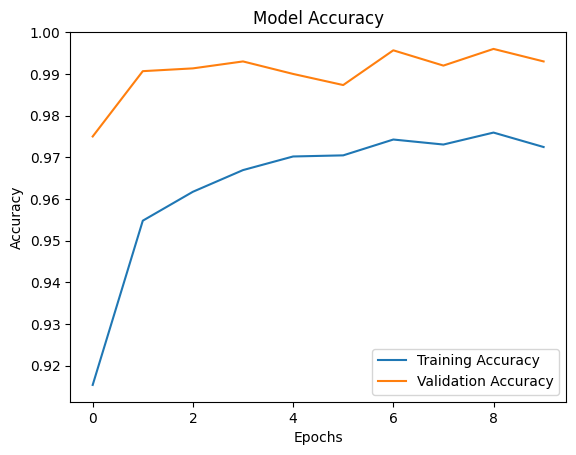

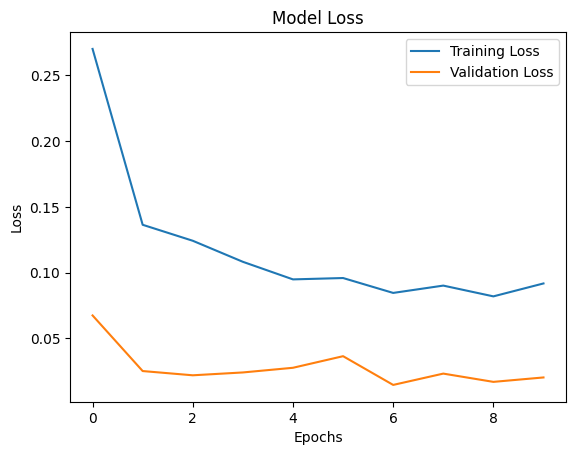

In [ ]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# menyimpan model hasil fine-tune
model.save('/content/fine_tuned_model.h5')

# **Prediksi**

In [ ]:
!unzip Bahan\ Makanan.zip -d trial

Archive:  Bahan Makanan.zip
replace trial/Bahan Makanan/bahan makanan.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediksi: [[5.8394369e-09 2.5771251e-11 3.6869119e-10 4.7533657e-08 8.0793877e-10
  1.0000000e+00 2.1810080e-11 1.2412749e-11 9.2019048e-10 1.1426974e-09
  2.6266655e-08 1.7506360e-10 8.1977020e-10 9.4263139e-12 1.7189858e-08]]


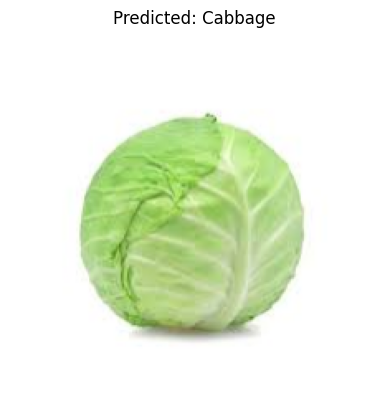

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load fine-tuned model
model_path = "/content/fine_tuned_model.h5"
model = load_model(model_path)

# Membaca gambar
img_path = "/content/trial/Bahan Makanan/kubis.jpg"
img = cv2.imread(img_path)

# Cek apakah gambar berhasil dimuat
if img is None:
    print("Gambar tidak dapat dimuat, periksa ulang path gambar.")
else:
    # Ubah ukuran gambar agar sesuai dengan input model
    img_resized = cv2.resize(img, (224, 224))

    # Convert ke format RGB
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Normalisasi gambar
    img_rgb = img_rgb / 255.0

    # Tambahkan dimensi batch untuk input model
    img_batch = np.expand_dims(img_rgb, axis=0)

    # Melakukan prediksi
    predictions = model.predict(img_batch)
    print("Prediksi:", predictions)

    # Menampilkan hasil prediksi
    predicted_class = np.argmax(predictions, axis=1)
    predicted_class_name = class_names[predicted_class[0]]

    # Visualisasi gambar dengan Matplotlib
    plt.imshow(img_rgb)
    plt.title(f'Predicted: {predicted_class_name}')  # Judul dengan nama kelas yang diprediksi
    plt.axis('off')
    plt.show()

In [ ]:
# menampilkan hasil prediksi untuk memahami struktur output
print(f"Predictions structure: {predictions}")
print(f"Shape of predictions: {predictions.shape}")

Predictions structure: [[5.8394369e-09 2.5771251e-11 3.6869119e-10 4.7533657e-08 8.0793877e-10
  1.0000000e+00 2.1810080e-11 1.2412749e-11 9.2019048e-10 1.1426974e-09
  2.6266655e-08 1.7506360e-10 8.1977020e-10 9.4263139e-12 1.7189858e-08]]
Shape of predictions: (1, 15)


In [ ]:
# convert ke JSON format menggunakan tensorflow.js

import subprocess

# Path tujuan untuk menyimpan model dalam format TensorFlow.js
output_path = "/content/TFJS"

# Perintah tensorflowjs_converter
command = [
    "tensorflowjs_converter",
    "--input_format=keras",
    "--output_format=tfjs_layers_model",
    model_path,
    output_path
]

try:
    subprocess.run(command, check=True)
    print("Model berhasil dikonversi ke format TensorFlow.js dan disimpan di:", output_path)
except subprocess.CalledProcessError as e:
    print("Terjadi kesalahan saat mengonversi model:", e)

2024-12-04 17:34:04.657881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733333644.678900   15984 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733333644.685541   15984 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!


failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi ke format TensorFlow.js dan disimpan di: /content/TFJS


In [ ]:
# convert ke TFLite

# load model Keras
model_keras = tf.keras.models.load_model(model_path)

# buat converter untuk model TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_keras)

# Select mode of optimization
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

converter.optimizations = [optimization]

# Konversi ke format TFLite
tflite_model = converter.convert()

# Simpan model TFLite ke file
tflite_model_path = "model.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"Model berhasil dikonversi ke TFLite dan disimpan di: {tflite_model_path}")

Saved artifact at '/tmp/tmppd6fafsg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  134763748232704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134763748240448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134763748238864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134763748239392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134763748240976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134763748245200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134763748239744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134763748242560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134763748242384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134763748244320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134763748243

W0000 00:00:1733334982.219424   13964 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1733334982.219478   13964 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-12-04 17:56:22.219882: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppd6fafsg
2024-12-04 17:56:22.246470: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-12-04 17:56:22.246523: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmppd6fafsg
2024-12-04 17:56:22.494184: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-12-04 17:56:23.732807: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmppd6fafsg
2024-12-04 17:56:24.115902: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1896024 microseconds.


Model berhasil dikonversi ke TFLite dan disimpan di: model.tflite
